Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import papermill as pm
import logging
from IPython.display import Image, display
import sys


In [2]:
import os
import subprocess
from pathlib import Path

"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [3]:
#I found this helpful logger code online in a github issue post and modified it to suppress what I want, makes the output look nicer
class PapermillFilter(logging.Filter):
    def filter(self, record):
        #suppress these annoying console logs
        return not ('Executing Cell' in record.getMessage() or 'Ending Cell' in record.getMessage())

# Apply the custom filter to papermill's logger
logger = logging.getLogger('papermill')
logger.setLevel(logging.INFO)  #Info level will show ipynb prints
handler = logging.StreamHandler()
handler.addFilter(PapermillFilter())  # Apply our filter
logger.addHandler(handler)

Data Cleaning Pipeline

In [4]:
#To run the data pipelin, run the pipeline.py file in 'streamliningData'
#You will need to have the data in a folder called 'baseData'

The graphs shown here are based on the BeerAdvocate data, since it contains the majority of the US data, and the RateBeer graphs are similar.

In [5]:
#data
BA_breweries = pd.read_csv('data/minimizedData/BA_breweries_small.csv')
BA_users = pd.read_csv('data/minimizedData/BA_users_small.csv')
BA_merged = pd.read_csv('data/minimizedData/BA_ratings_small_plus.csv')

#US data
BA_US_ratings = pd.read_csv('data/USData/BA_US_states_all.csv')
neighbours_df = pd.read_csv('data/additionalData/bordering_states.csv', dtype={'state': 'string', 'neighbours': 'string'})
neighbours_df["neighbours"] = neighbours_df["neighbours"].fillna("").apply(lambda x: x.split(";") if x else [])


Preliminary data analysis: selecting the locations of interest <br>

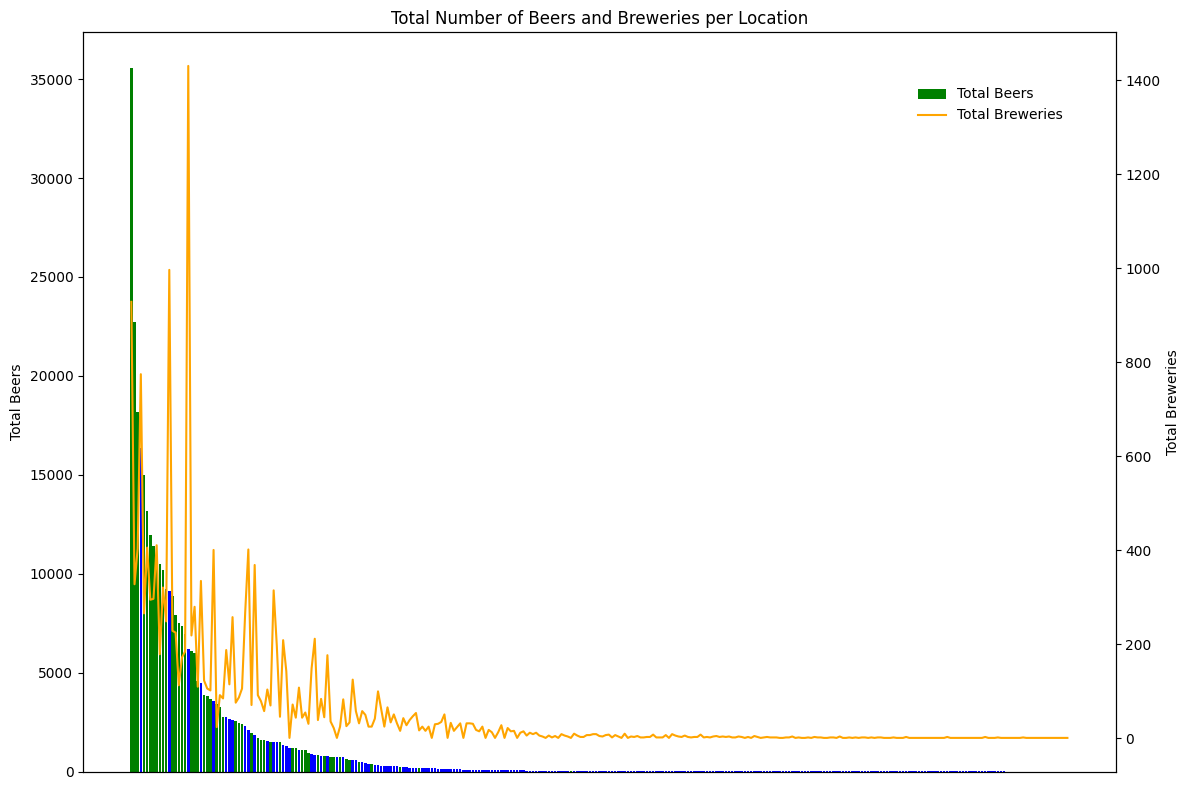

In [6]:

from src.choosingCountries.utils.beers_breweries import plot_beer_breweries_distribution

plot_beer_breweries_distribution(BA_breweries)

In the figure above the green locations are US states and the blue represent all other countries, the orange line is breweries. We can see that most of the locations selling high amounts of beers are based in the US. Brewery locations are offset for visibility. Since the majority of beers are being produced by the US, focusing only on the US won't be limiting the amount of data we have that much.

Number of users with known locations: 122425


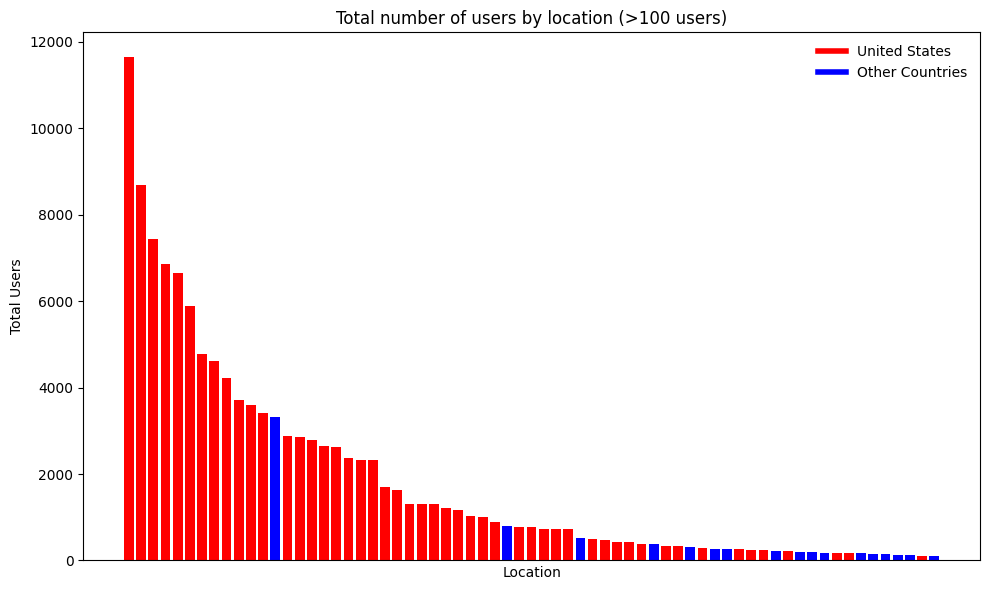

In [7]:
from src.choosingCountries.utils.users import plot_users

plot_users(BA_users)

The distribution of users by location of origin (location must have more than 100 users). Again we see most of them are from the US, so focusing only on the US won't be limiting the amount of data we have too much.

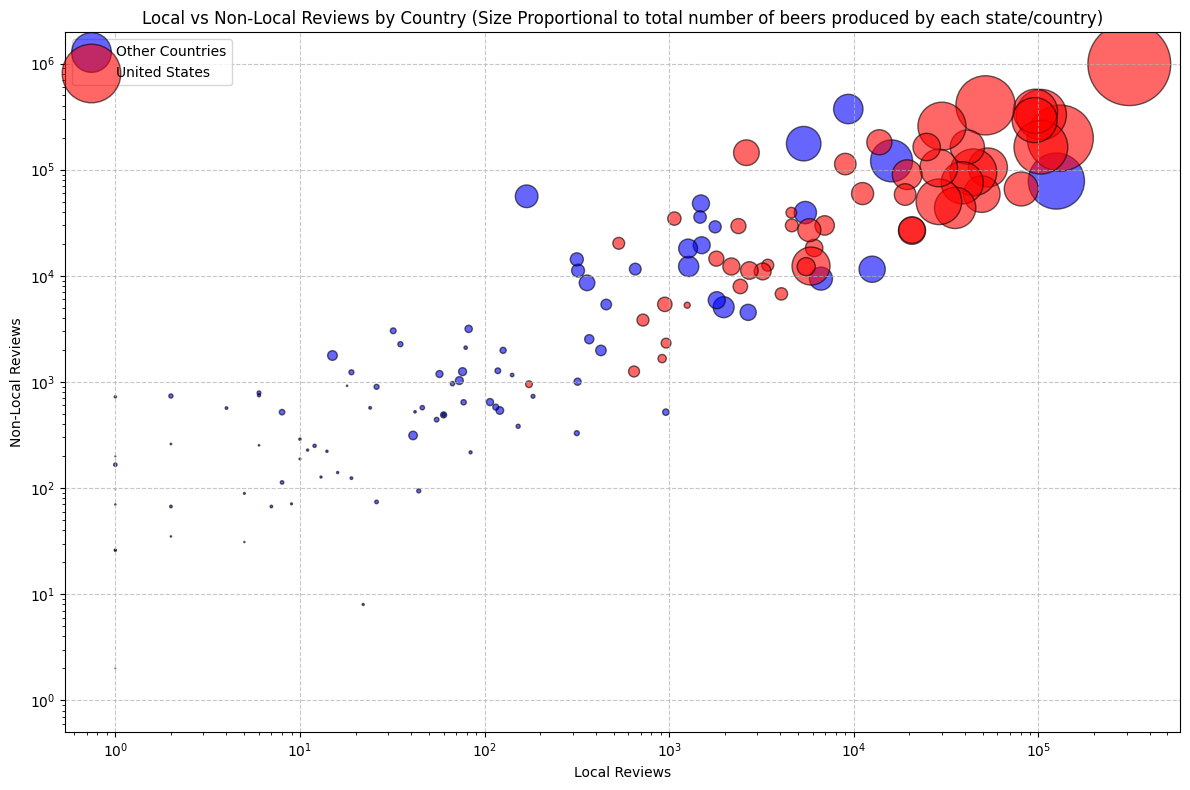

In [8]:
from src.choosingCountries.utils.reviews import plot_reviews

plot_reviews(BA_breweries, BA_merged)

Once again, the US dominates, with most of the top right corner (so biggest number of reviews) being occupied by the US.

In conclusion, the number of beers produced by each location is proportional to the number of both local and non local reviews. We can see directly from the graphics that the US states has a substantial number of data points when looking at the number of beer produced, the number of reviews as well as the origin of the users. Therefore we will be restricting our analysis to the US states. Furthermore the distributions for all of these considerations decrease substantially for the countries on the lower end of the scale which is not interesting to us since we would not have enough data to analyse anyways.

From here on out, we will only be looking at US data, and doing analyses on US states.

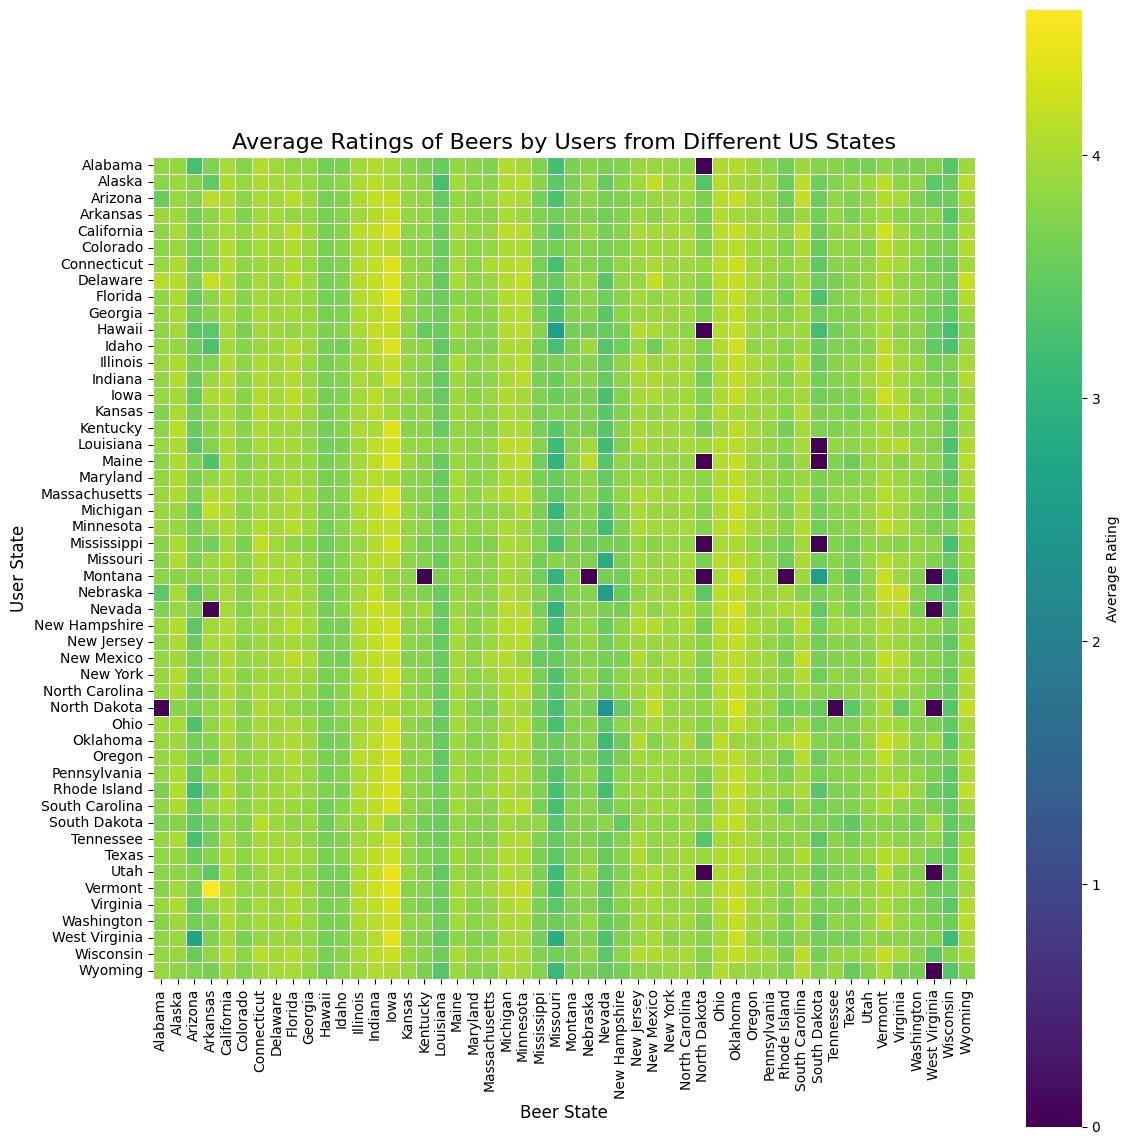

In [9]:
from src.choosingCountries.utils.heatmap import heatmap_avg_ratings

heatmap_avg_ratings(BA_US_ratings)

Here we see average ratings of beers coming from a specific state by users coming from a specific state. We were trying to see if any obvious patterns jumped out at us such as people from Alabama preferring beer from Alabama but it doesn't really seem so. All we can say is that beers coming from some states seem to be better rated than others, like Iowa, and beers coming from certain states are rated consistently lower, like Missouri. We replaced NaNs with 0's here, which is why we sometimes get these dark spots.

Q1: Regional analysis, do states in a region have similar taste in beer?

We define regions as a state and its neighbours. So we have 50 regions, and a lot of overlap, which is fine.

In [10]:
#this is Thomas' question
path = 'modules/9.ipynb'
pm.execute_notebook(
    path,
    path, #dont want to make new file
    log_output=True,
    progress_bar=False,
    report_mode=True
)

display(Image(filename='modules/9.png'))

Input Notebook:  modules/9.ipynb
Output Notebook: modules/9.ipynb
Executing notebook with kernel: python3


KeyboardInterrupt: 

We plotted only the Massachusetts centered region as an example. We calculate Cohen's D for each pair-wise interaction in the region, so we're looking at the distribution of beer ratings for beers coming from that region and rated by users from that region. We see a low Cohen's D, indicating that the states in the region have 'similar' or at the very least not significantly (in the Cohen's D sense) different distributions of ratings. Some regions do have inter-state differences (like the Missouri region), which is to expected.
<br>
Talk about the algorithm, how did we make these groups, talk about the cohens D calcualtion.
<br>
**Insert the map here**

Q2 Are regions biased when they rate each other?

c:\Users\Enzo\Desktop\ada-2024-project-x0x0\src\questions\question2\utils\regions_cohenD.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cohen_by_region_df, x='Center State of each Region', y='Cohen_d', palette='viridis')


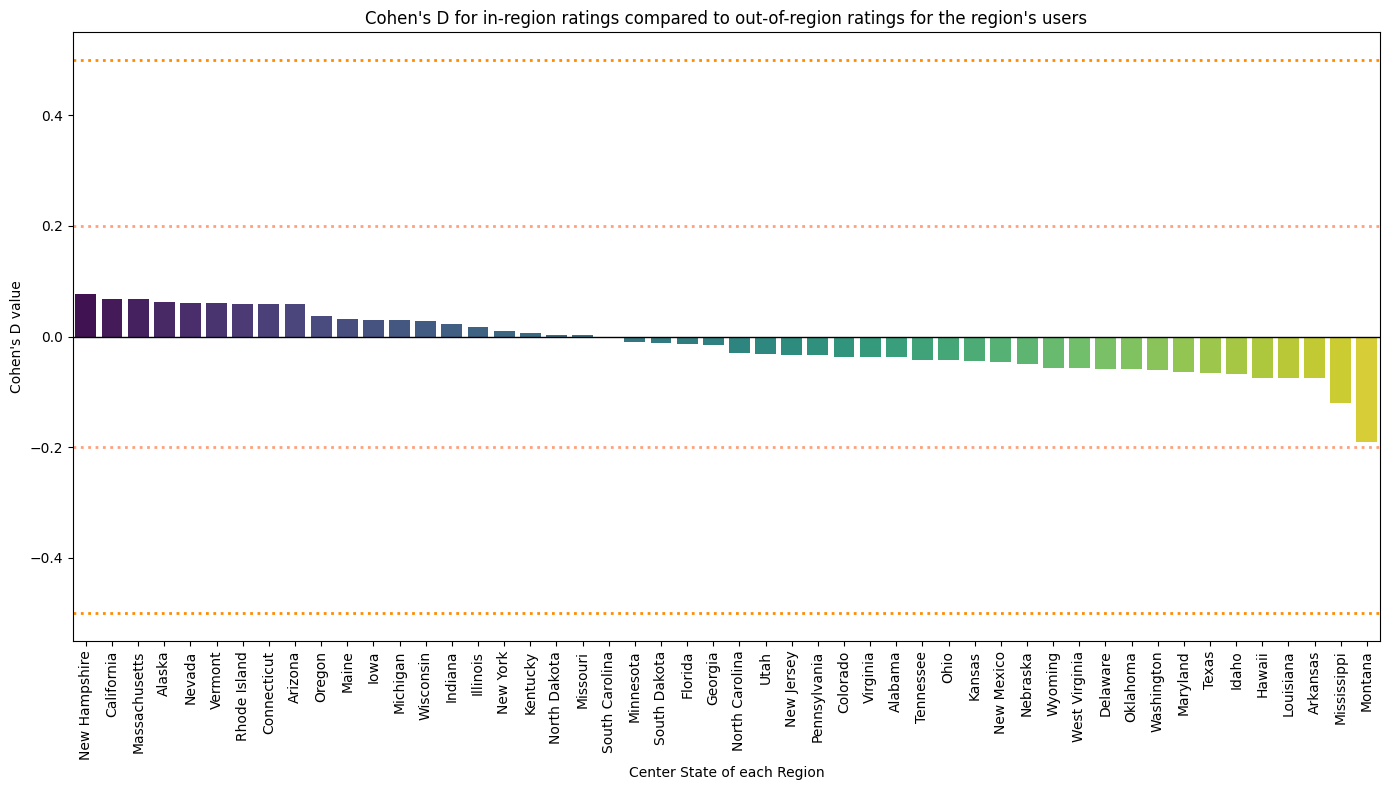

In [11]:
from src.questions.question2.utils.regions_cohenD import regions_cohenD

cohen_by_region_df = regions_cohenD(neighbours_df, BA_US_ratings)

When comparing regions to eachother, we don't really see many significant differences (Cohen's D > 0.2), there's maybe one region (Montana region) that could be different from the other regions. This is surprising! Instead of using our state and neighbours region to see differences, we can try to use the areas generated in question 1 and see if they are different. <br>
**Insert another graph** <br>
Unfortunately, these too are not significanlty different from eachother in terms of avg ratings.
So this motivates us to look at things on a state-by-state level, will there be differences there?

Q3: State Specific analysis of in state and out state reviews

c:\Users\Enzo\Desktop\ada-2024-project-x0x0\src\questions\question3\utils\state_scatter.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]],


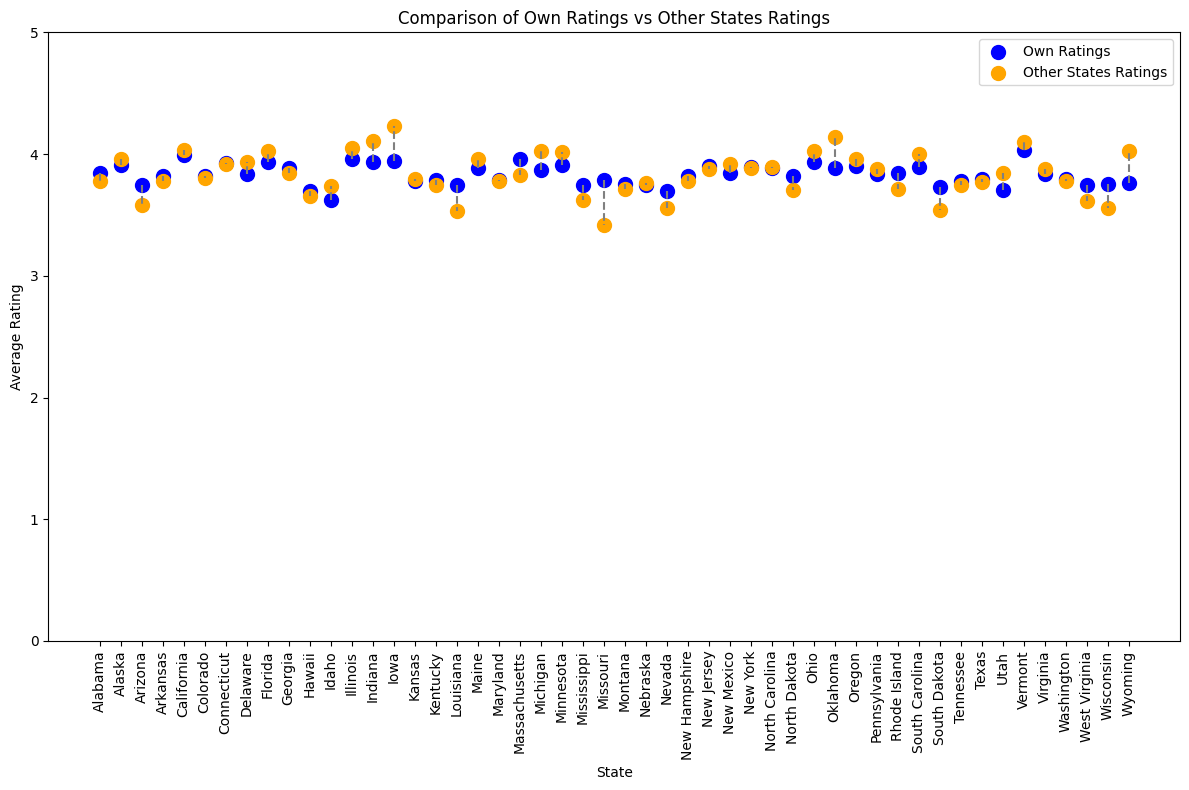

c:\Users\Enzo\Desktop\ada-2024-project-x0x0\src\questions\question3\utils\state_cohenD.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


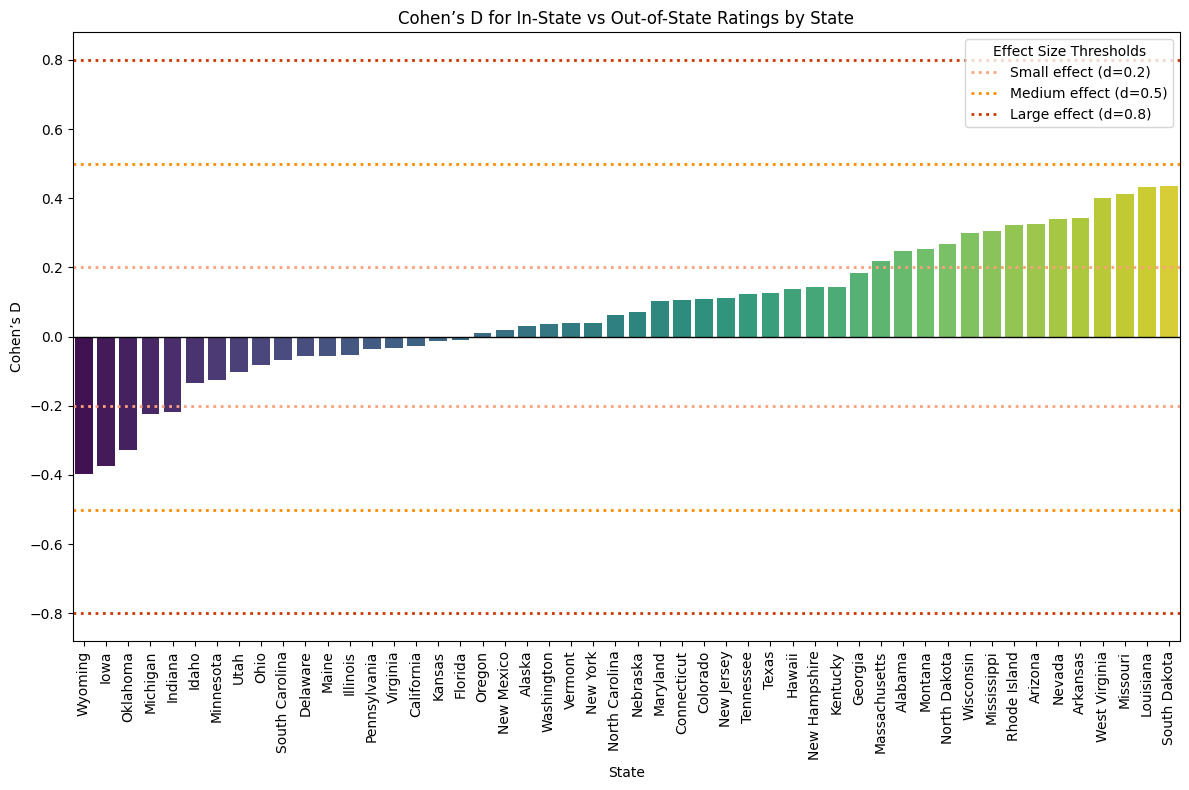

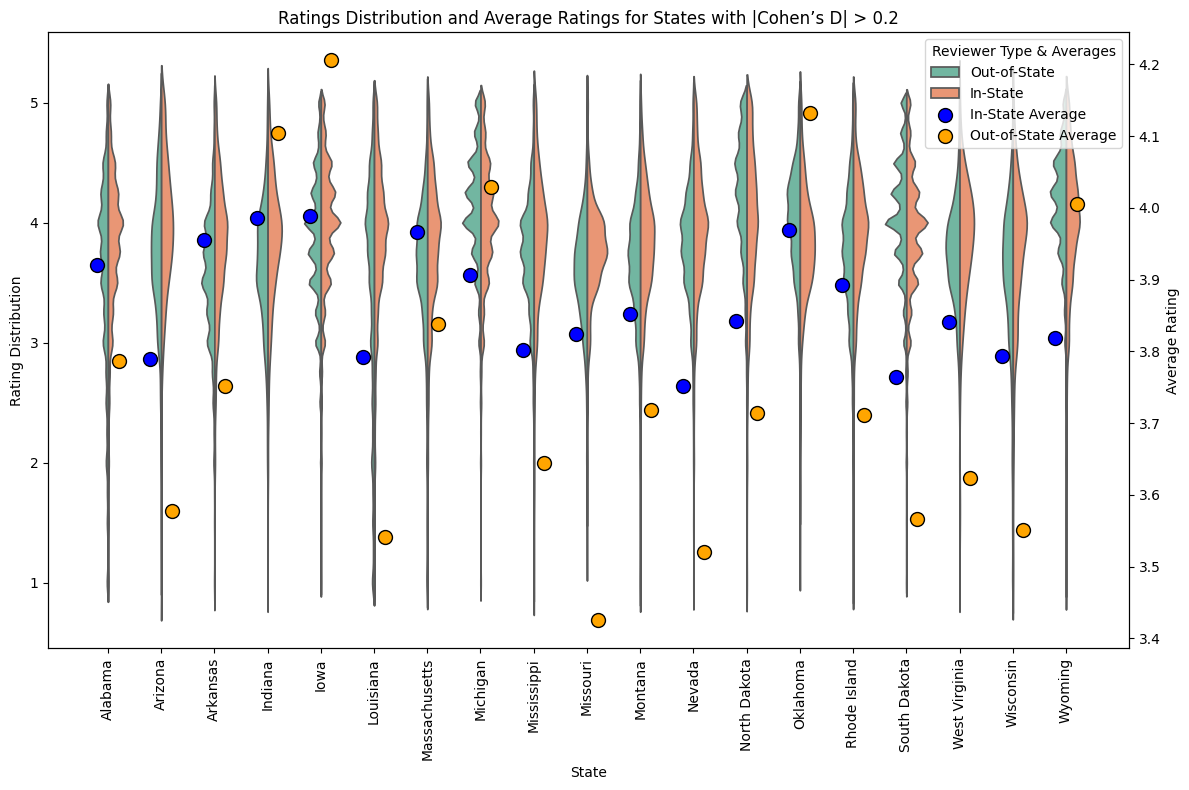

In [12]:
from src.questions.question3.stateBias import state_bias

state_bias(BA_US_ratings)



Trying to see if theres any big differences, it doesn't seem so. So we'll next test for significance.

We're using Cohen's D here since our sample sized is very big (in the milions!). Here we find that there are significant effect sizes for some of the states, cool!

Looking in detail at those significant states, we just wanted to get a general feel of what the distribution looked like.

Input Notebook:  modules/8.ipynb
Output Notebook: modules/8.ipynb
Executing notebook with kernel: python3
C:\Users\Enzo\AppData\Local\Temp\ipykernel_29628\1844618957.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')

<Figure size 1200x800 with 1 Axes>


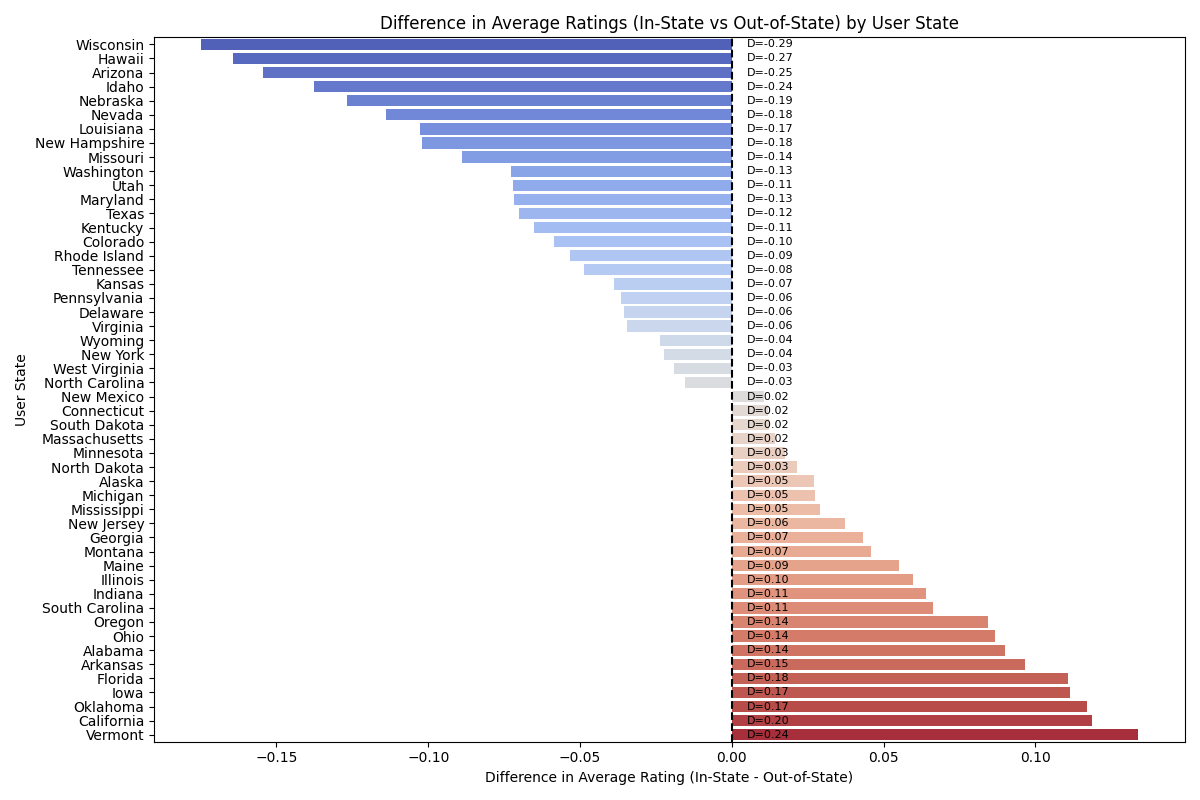

In [13]:
path = 'modules/8.ipynb'
pm.execute_notebook(
    path,
    path, #dont want to make new file
    log_output=True,
    progress_bar=False,
    report_mode=True
)

display(Image(filename='modules/8.png'))

Here we are plotting the difference in averages with the significance (Cohen's D) level.

Conclusion: There are significant differences between distribution of ratings, even on a state level!

For questions 4, we're still working on it, but we dont really have significant results...

For question 5, we have not started working on it yet.

Thanks for reading!